In [4]:
import pandas as pd
import numpy as np
import seaborn as sns

## Get the dataset

In [5]:
data = pd.read_excel("Folds5x2_pp.xlsx")

In [6]:
data.head()

,AT,V,AP,RH,PE
0,14.96,41.76,1024.07,73.17,463.26
1,25.18,62.96,1020.04,59.08,444.37
2,5.11,39.40,1012.16,92.14,488.56
3,20.86,57.32,1010.24,76.64,446.48
4,10.82,37.50,1009.23,96.62,473.90


In [7]:
data.shape

(9568, 5)

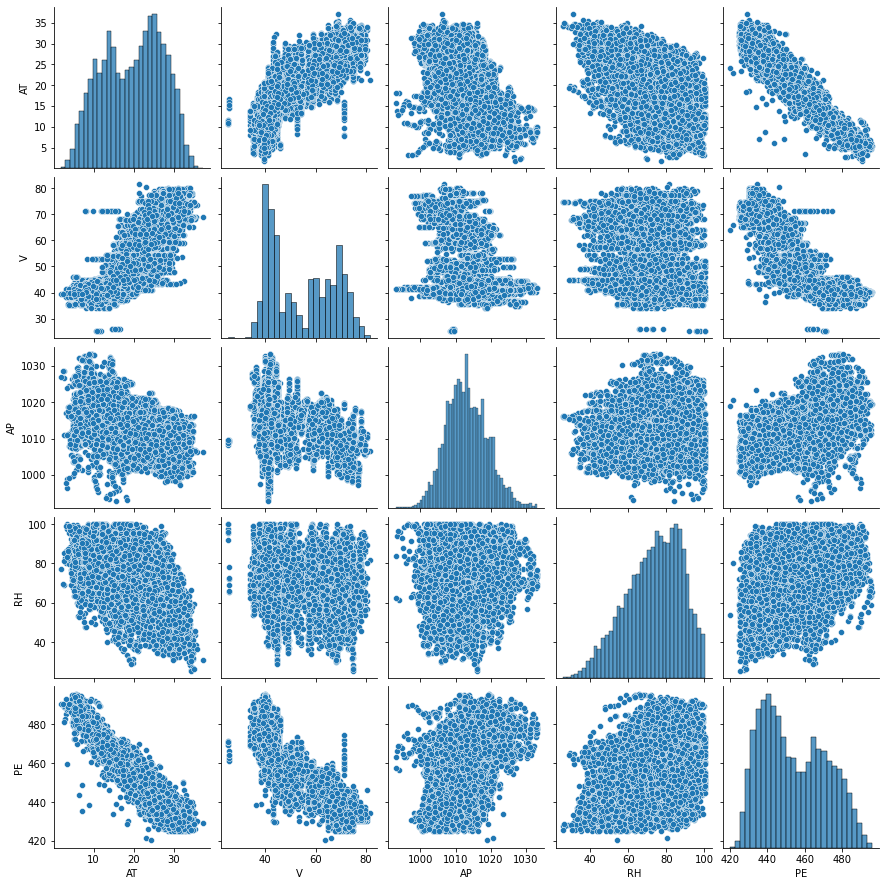

In [8]:
sns.pairplot(data)

In [9]:
data.corr()

,AT,V,AP,RH,PE
AT,1.000000,0.844107,-0.507549,-0.542535,-0.948128
V,0.844107,1.000000,-0.413502,-0.312187,-0.869780
AP,-0.507549,-0.413502,1.000000,0.099574,0.518429
RH,-0.542535,-0.312187,0.099574,1.000000,0.389794
PE,-0.948128,-0.869780,0.518429,0.389794,1.000000


### from the above visualization and the correlation matrix, we can clearly see that the target PE variable is more correlated with AT and V features, so they are the most predictive features. It can be seen clearly that AT and V are also high correlated with each other, so we must fix this.

In [10]:
def cleanData(data):
    data_without_v = data.drop(columns ='V',axis= 1)
    y = data.copy()
    y["AT_V"] = y['AT'] + y['V']
    y.drop(columns =['AT','V'],axis = 1, inplace = True)
    data_V_and_AT_combined = y[['AT_V', 'AP', 'RH','PE']]
    return data_without_v, data_V_and_AT_combined

In [11]:
data_1 , data_2 = cleanData(data)

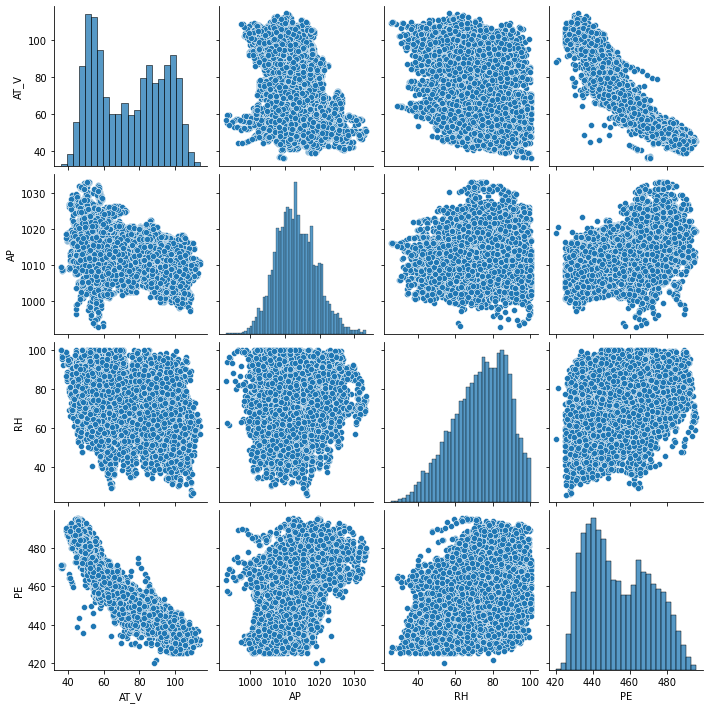

In [12]:
sns.pairplot(data_2)

In [13]:
def removeOutlier(data):
    """ 
    remove outlier in AT_V
    column
    """
    x1 =  data.drop(data[(data['AT_V'] < 60) & (data['PE'] < 460)].index)
    x2 =  x1.drop(x1[(x1['AT_V'] < 50) & (x1['PE'] < 475)].index)     
    return x2

In [14]:
y_withoutOutlier = removeOutlier(data_2)

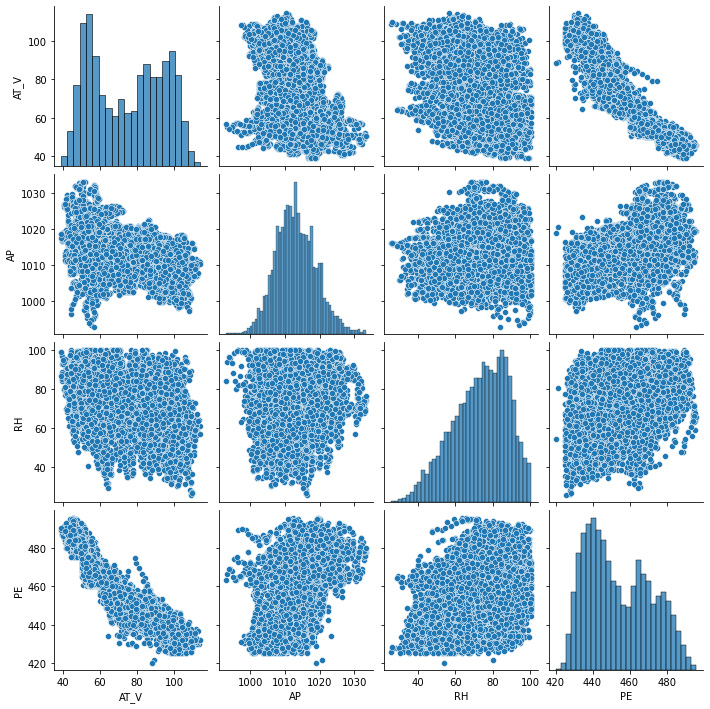

In [15]:
sns.pairplot(y_withoutOutlier)

In [16]:
data.iloc[:, :-1]

,AT,V,AP,RH
0,14.96,41.76,1024.07,73.17
1,25.18,62.96,1020.04,59.08
2,5.11,39.40,1012.16,92.14
3,20.86,57.32,1010.24,76.64
4,10.82,37.50,1009.23,96.62
...,...,...,...,...
9563,16.65,49.69,1014.01,91.00
9564,13.19,39.18,1023.67,66.78
9565,31.32,74.33,1012.92,36.48
9566,24.48,69.45,1013.86,62.39


In [17]:
def normalize_data(data):
    data.iloc[:, :-1] =  data.iloc[:, :-1]/ data.iloc[:, :-1].max()

In [414]:
def split_data(df, split_percent):
    df = data.copy()
    normalize_data(df)
    X = df[df.columns[:-1]]
    y = df[df.columns[-1]]
    indices = np.arange(len(X))
    np.random.shuffle(indices)
    train_index = int((1 - split_percent) * len(indices))
    x_train, x_test = X[:train_index], X[train_index:]
    y_train, y_test = y[:train_index], y[train_index:]
    return x_train.to_numpy(),y_train.to_numpy(), x_test.to_numpy(), y_test.to_numpy()

In [415]:
np.random.seed(10)
x_train,y_train, x_test, y_test = split_data(data, split_percent = 0.2)

In [418]:
x_test

array([[0.1738076 , 0.43857283, 0.98602536, 0.67731629],
       [0.64295338, 0.91871015, 0.98410916, 0.71325879],
       [0.7318782 , 0.58153507, 0.97664763, 0.45716853],
       ...,
       [0.84397736, 0.9113536 , 0.98027678, 0.36421725],
       [0.65966047, 0.85152035, 0.98118649, 0.62290335],
       [0.58205335, 0.76655223, 0.98444789, 0.67761581]])

#### Linear regression

In [447]:
class LR:
    def __init__(self, lr = 0.01, max_iters = 1000, l1 = 0.01, l2 = 0.2):
        self.theta = None
        self.lr = lr
        self.max_iters = max_iters
        self.l1 = l1
        self.l2 = l2
    def fit(self, X,y):
        # init theta
        self.theta = np.zeros(X.shape[1])
        costs = []
        max_iters_list = []
        for _ in range(self.max_iters):
            lambda_norm1 = ((self.theta > 0).astype(float) * 2-1) * self.l1
            lambda_norm2 = self.theta * self.l2 
            gradient = X.T @ (X @ self.theta - y) + lambda_norm2 + lambda_norm1
            self.theta = self.theta - self.lr * gradient
            cost = self.MSE(X @ self.theta, y)
            if _ % 100 == 0 :
                costs.append(cost)
                max_iters_list.append(_)
        return costs, max_iters_list
    def predict(self, X):
        y_pred = X @ self.theta
        return y_pred
    def MSE(self, yh, y):
        mes = np.sum((yh - y)**2) / len(y)
        return mes

In [488]:
model = LR(lr = 1e-5, max_iters = 100000, l1 = 0, l2 = 0)

In [490]:
cost = model.fit(x_train, y_train)
cost[0]

[142968.8658849392,
 1694.1476681053878,
 1228.0864216542868,
 980.7910515427195,
 827.9728732402849,
 719.1102868986002,
 633.285299747361,
 561.5044677913671,
 499.6167077189724,
 445.4716835176154,
 397.7756719100698,
 355.6273776208842,
 318.32651791840516,
 285.2921899840097,
 256.0257395561502,
 230.09194689998154,
 207.10799565036982,
 186.73595777255537,
 168.67704141083968,
 152.66685929573364,
 138.47138451212453,
 125.88342827297384,
 114.71954517381694,
 104.81730299966972,
 96.03286968134542,
 88.23887876265034,
 81.32254050626877,
 75.18397007337146,
 69.73470770570351,
 64.89640880376297,
 60.599684367931054,
 56.78307452665068,
 53.39213986553955,
 50.378657029242184,
 47.699906622529745,
 45.318042812726254,
 43.19953525289629,
 41.314675022654924,
 39.63713723710619,
 38.14359381848203,
 36.81337067218162,
 35.62814417019644,
 34.571672430252775,
 33.629557397093606,
 32.78903419092336,
 32.03878459394828,
 31.36877190524513,
 30.77009471221434,
 30.234857408374737,
 

In [489]:
# class LR:
#     def __init__(self, lr = 0.01, max_iters = 1000):
#         self.theta = None
#         self.lr = lr
#         self.max_iters = max_iters
#     def fit(self, X,y):
#         # init theta
#         self.theta = np.zeros(X.shape[1])
        
#         for i in range(self.max_iters):
#             gradient = X.T @ (X @ self.theta - y)
#             self.theta = self.theta - self.lr * gradient
#             #print(self.theta)
#         return self.theta
#     def predict(self, X):
#         y_pred = X @ self.theta
#         return y_pred
#     def MSE(self, yh, y):
#         mes = np.sum((yh - y)**2) / len(y)
#         return mes

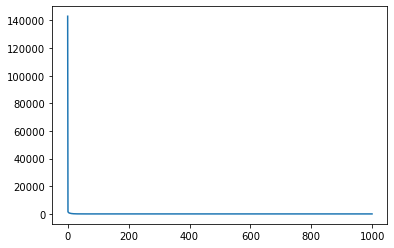

In [491]:
import matplotlib.pyplot as plt
plt.plot(np.arange(len(cost[0])), cost[0])

In [492]:
yh = model.predict(x_test)
yh

array([485.00556528, 443.76796414, 444.24727797, ..., 432.89743557,
       443.58499839, 451.43366282])

In [493]:
model.MSE(yh, y_test)

26.328542073078097

### Model Implementation

#### Batch Gradient Descent

In [1]:
import numpy as np
class BGD():
    "Implementation of batch gradient descent"
    def __init__(self, learning_rate = 1e-5 ,  max_iter = 500, initial_theta_strategy = 'normal', store_cost_while_fitting = False):
        self.learning_rate = learning_rate
        self.max_iter = max_iter
        self.initial_theta_strategy = initial_theta_strategy
        self.store_cost_while_fitting = store_cost_while_fitting
    
    def fit(self, X,y):
        """
        Computes the value of theta, 
        which is stored in self.theta,
        Parameters
        ------------------------------------------
        X: numoy array, an array of the features 
           also it should be scaled
        y: numpy array, an array of the target

        Returns
        ------------------------------------------
        None
        """
        N = len(X) # number of trainning examples
        d = len(X[0]) # number of features
        X_arr = X # convert the data frame to numpy array
        y_arr = y.reshape((N,1)) # convert the data frame to numpy array
        cost_arr = []
        self._initialize_theta(d)
        counter = 0
        while counter < self.max_iter:
            self.theta -= self.learning_rate * X_arr.T @ (X_arr @ self.theta - y_arr)
            
            if self.store_cost_while_fitting:
                cost_arr.append(self.cost(X, y))
            counter += 1
        if self.store_cost_while_fitting:
            return cost_arr

    def predict(self, X):
        result = X @ self.theta
        return result
    def cost(self, X, y):
        N = len(X) # the number of training examples
        y = y.reshape(N,1)
        predictions = self.predict(X)
        result = np.dot((predictions - y).T, predictions - y)/N
        return result[0][0]

    def _initialize_theta(self,d):
        
        if self.initial_theta_strategy == "normal":
            self.theta = np.random.randn(d,1)
        elif self.initial_theta_strategy == 'zeros':
            self.theta = np.zeros((d,1))
        elif self.initial_theta_strategy == 'ones':
            self.theta = np.ones((d,1))


In [382]:
model = BGD(store_cost_while_fitting=True, learning_rate=1e-5, max_iter=10000)

In [383]:
cost = model.fit(x_train, y_train)
cost

[143912.84624994596,
 99751.43501796908,
 69394.88507025063,
 48526.425291106156,
 34179.14741315038,
 24313.901138303376,
 17529.182320423603,
 12861.739708399446,
 9649.532369725292,
 7437.540608855783,
 5913.030004602843,
 4861.058515824763,
 4133.896606421869,
 3630.009759957808,
 3279.6132050524557,
 3034.74370775483,
 2862.435934784346,
 2740.0325819607333,
 2651.9610350707308,
 2587.517975470042,
 2539.3467440341524,
 2502.390836501288,
 2473.1746429445625,
 2449.3091014629745,
 2429.151934953792,
 2411.574132519853,
 2395.799452596679,
 2381.2941137580196,
 2367.690979410028,
 2354.737450064526,
 2342.2596497829563,
 2330.13781157061,
 2318.2893597866105,
 2306.6572826972406,
 2295.2021409341264,
 2283.896574902566,
 2272.721529713374,
 2261.663660565289,
 2250.713549448839,
 2239.8644794699567,
 2229.111592424706,
 2218.4513097818835,
 2207.8809347055094,
 2197.398378505831,
 2187.0019726099886,
 2176.690339310327,
 2166.46230291066,
 2156.3168286381256,
 2146.252980638462,
 2

In [306]:
cost[-1]

25.371211325276427

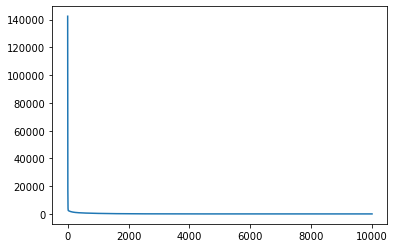

In [307]:
plt.plot(np.arange(len(cost)), cost)

In [2221]:
optimal_theta = np.linalg.inv(x_train.T @ x_train) @ x_train.T @ y_train

In [2222]:
optimal_theta

array([-62.80092347, -21.68088108, 519.64998731, -10.27374543])

In [2223]:
prediction_opt = x_test @ optimal_theta

In [2224]:
prediction_opt

array([485.00556528, 443.76796414, 444.24727797, ..., 432.89743557,
       443.58499839, 451.43366282])

In [2225]:
np.sum((prediction_opt - y_test)**2)/len(y_test)

26.328542073082378

In [2226]:
predictions = model.predict(x_test)

In [2227]:
print(predictions)

[[484.47804371]
 [443.30506105]
 [444.59121322]
 ...
 [432.40263603]
 [443.20477758]
 [451.17442672]]


In [2228]:
np.sum((predictions.reshape(-1) - y_test)**2)/ len(y_test)

26.272957829598123

In [2229]:
y_test

array([483.12, 444.38, 442.85, ..., 429.57, 435.74, 453.28])

## Stochastic Gradient Descente

In [2230]:
import numpy as np
import random
class SGD:
    "Implementation of stochastic batch gradient descent"
    def __init__(self, learning_rate = 1e-4 ,  max_iter = 100000, initial_theta_strategy = 'normal', store_cost_while_fitting = False):
        self.learning_rate = learning_rate
        self.max_iter = max_iter
        self.initial_theta_strategy = initial_theta_strategy
        self.store_cost_while_fitting = store_cost_while_fitting
    
    def fit(self, X,y):
        """
        Computes the value of theta, 
        which is stored in self.theta,
        Parameters
        ------------------------------------------
        X: numoy array, an array of the features 
           also it should be scaled
        y: numpy array, an array of the target

        Returns
        ------------------------------------------
        None
        """
        N = len(X) # number of trainning examples
        d = len(X[0]) # number of features
        X_arr = X.copy() # convert the data frame to numpy array
        y_arr = y.reshape((N,1)).copy() # convert the data frame to numpy array
        cost_arr = []
        self._initialize_theta(d)
        counter = 0
        while counter < self.max_iter:
            #np.random.shuffle(X_arr)
            indices = np.arange(len(X_arr))
            np.random.shuffle(indices)
            X_arr = X_arr[indices]
            y_arr = y_arr[indices]
            for i in range(0,N):
                #print(y_arr[i])
                self.theta -= self.learning_rate * X_arr[i, :].reshape(d,1) * (np.dot(X_arr[i,:],self.theta) - y_arr[i])
            if self.store_cost_while_fitting:
                cost_arr.append(self.cost(X, y))
            counter += 1
        if self.store_cost_while_fitting:
            return cost_arr

    def predict(self, X):
        result = X @ self.theta
        return result
    def cost(self, X, y):
        N = len(X) # the number of training examples
        y = y.reshape(N,1)
        predictions = self.predict(X)
        result = np.dot((predictions - y).T, predictions - y)/N
        return result[0][0]

    def _initialize_theta(self,d):
        
        if self.initial_theta_strategy == "normal":
            self.theta = np.random.randn(d,1)
        elif self.initial_theta_strategy == 'zeros':
            self.theta = np.zeros((d,1))
        elif self.initial_theta_strategy == 'ones':
            self.theta = np.ones((d,1))



In [2231]:
sgd_model = SGD(store_cost_while_fitting=True, max_iter = 10, learning_rate=1e-2)

In [2232]:
cost = sgd_model.fit(x_train, y_train)

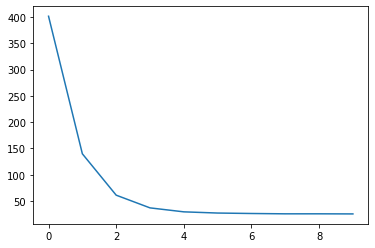

In [2233]:
plt.plot(np.arange(len(cost)), cost)

In [2243]:
cost[-1]

25.414362996859445

In [2244]:
predictions = sgd_model.predict(x_test)

In [2245]:
predictions = predictions.reshape(len(predictions))

In [2246]:
predictions

array([484.77722569, 443.41186267, 444.64489723, ..., 432.34892361,
       443.28920475, 451.31027976])

In [2247]:
y_test

array([483.12, 444.38, 442.85, ..., 429.57, 435.74, 453.28])

In [2248]:
np.sum((predictions.reshape(-1) - y_test)**2) / len(y_test)

26.328660164405754

### Mini-Batch Gradient Descent

In [2249]:

import numpy as np

class MBGD:
    "Implementation of batch gradient descent"
    def __init__(self, learning_rate = 1e-5 , batch_size = 16, max_iter = 500, initial_theta_strategy = 'normal', store_cost_while_fitting = False):
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.max_iter = max_iter
        self.initial_theta_strategy = initial_theta_strategy
        self.store_cost_while_fitting = store_cost_while_fitting
    
    def fit(self, X,y):
        """
        Computes the value of theta, 
        which is stored in self.theta,
        Parameters
        ------------------------------------------
        X: numoy array, an array of the features 
           also it should be scaled
        y: numpy array, an array of the target

        Returns
        ------------------------------------------
        None
        """
        X_arr = X # convert the data frame to numpy arrayk
        N = len(X_arr) # number of trainning examples
        y_arr = y.reshape((N,1)) # convert the data frame to numpy array
        d = len(X_arr[0]) # number of features
        assert self.batch_size < N # ensure that batch size is less than N        
        no_epochs = N // self.batch_size
        cost_arr = []
        self._initialize_theta(d)
        counter = 0
        while counter < self.max_iter:
            for i in range(no_epochs-1):
                X_current = X_arr[ i * self.batch_size : (i+1) * self.batch_size ,:]
                y_current = y_arr[ i * self.batch_size : (i+1) * self.batch_size ,:]
                self.theta -= self.learning_rate * X_current.T @ (X_current @ self.theta - y_current)
            if self.store_cost_while_fitting:
                cost_arr.append(self.cost(X_arr, y_arr)[0][0])
            counter += 1
        if self.store_cost_while_fitting:
            return cost_arr

    def predict(self, X):
        """
        Parameters
        ------------------------------------------
        X: numpy array, an array of the input features

        Returns
        ------------------------------------------
        result: numpy array, array of the predicted values
        """
        result = X @ self.theta
        return result
    def cost(self, X, y):
        """
        Parameters:
        ------------------------------------------
        X: numpy array, the input array
        y: numpy array, array of the target values

        Returns
        ------------------------------------------
        result: float, the mean squared error
        """
        N = len(X) # the number of training examples
        predictions = self.predict(X)
        result = np.dot((predictions - y).T, predictions - y)/N
        return result

    def _initialize_theta(self,d):
        """
        Parameters:
        -----------------------------------------
        d: int, the number of features
        """
        if self.initial_theta_strategy == "normal":
            self.theta = np.random.randn(d,1)
        elif self.initial_theta_strategy == 'zeros':
            self.theta = np.zeros((d,1))
        elif self.initial_theta_strategy == 'ones':
            self.theta = np.ones((d,1))

In [2250]:
model = MBGD(store_cost_while_fitting=True, learning_rate=1e-5, max_iter=5000, batch_size =16)


In [2251]:
cost = model.fit(x_train, y_train)

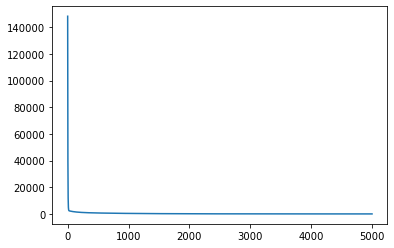

In [2252]:
plt.plot(np.arange(len(cost)), cost)


In [2253]:
x_test

array([[0.1738076 , 0.43857283, 0.98602536, 0.67731629],
       [0.64295338, 0.91871015, 0.98410916, 0.71325879],
       [0.7318782 , 0.58153507, 0.97664763, 0.45716853],
       ...,
       [0.84397736, 0.9113536 , 0.98027678, 0.36421725],
       [0.65966047, 0.85152035, 0.98118649, 0.62290335],
       [0.58205335, 0.76655223, 0.98444789, 0.67761581]])

In [2254]:
predictions = model.predict(x_test)

In [2255]:
y_n = y_test
p_n = predictions.reshape(-1)

In [2256]:
y_n

array([483.12, 444.38, 442.85, ..., 429.57, 435.74, 453.28])

In [2257]:
p_n

array([480.71484735, 443.20175116, 442.84022722, ..., 429.29533474,
       442.21107483, 450.43437078])

In [2258]:
np.sum((p_n - y_n)**2) / len(y_test)

29.62471712797899

# Regularization

## Batch Gradient Descent

In [2259]:
import numpy as np
class BGD_Reg:
    "Implementation of batch gradient descent"
    def __init__(self, learning_rate = 1e-5 ,  max_iter = 500, initial_theta_strategy = 'normal', store_cost_while_fitting = False, l1 = 0, l2 = 1):
        self.learning_rate = learning_rate
        self.max_iter = max_iter
        self.initial_theta_strategy = initial_theta_strategy
        self.store_cost_while_fitting = store_cost_while_fitting
        self.l1 = l1
        self.l2 = l2
    
    def fit(self, X,y):
        """
        Computes the value of theta, 
        which is stored in self.theta,
        Parameters
        ------------------------------------------
        X: numoy array, an array of the features 
           also it should be scaled
        y: numpy array, an array of the target

        Returns
        ------------------------------------------
        None
        """
        N = len(X) # number of trainning examples
        d = len(X[0]) # number of features
        X_arr = X # convert the data frame to numpy array
        y_arr = y.reshape((N,1)) # convert the data frame to numpy array
        cost_arr = []
        self._initialize_theta(d)
        counter = 0
        while counter < self.max_iter:
            self.theta -= self.learning_rate * (X_arr.T @ (X_arr @ self.theta - y_arr) + self._reg_grad())

            if self.store_cost_while_fitting:
                cost_arr.append(self.cost(X, y))
            counter += 1
        if self.store_cost_while_fitting:
            return cost_arr
        pass
        
    def predict(self, X):
        """
        Parameters
        ------------------------------------------
        X: numpy array, an array of the input features

        Returns
        ------------------------------------------
        result: numpy array, array of the predicted values
        """
        result = X @ self.theta
        return result

    def cost(self, X, y):
        """
        Parameters:
        ------------------------------------------
        X: numpy array, the input array
        y: numpy array, array of the target values

        Returns
        ------------------------------------------
        result: float, the mean squared error
        """
        N = len(X) # the number of training examples
        y = y.reshape(N,1)
        predictions = self.predict(X)
        result = np.dot((predictions - y).T, predictions - y)/N
        return result[0][0]

    def _initialize_theta(self,d):
        """
        initialize theta with values based on
        the attribute initial_theta_strategy
        Parameters:
        -----------------------------------------
        d: int, the number of features
        """
        if self.initial_theta_strategy == "normal":
            self.theta = np.random.randn(d,1)
        elif self.initial_theta_strategy == 'zeros':
            self.theta = np.zeros((d,1))
        elif self.initial_theta_strategy == 'ones':
            self.theta = np.ones((d,1))
    def _reg_grad(self):
        d = len(self.theta)
        return self.l2 * self.theta.reshape(d,1) + self.l1 * (2 * (self.theta > 0).astype(int) - 1).reshape(d,1) 

##### L2-Regularization

In [2260]:
model = BGD_Reg(max_iter=1000, learning_rate=1e-4, store_cost_while_fitting=True, l2 = .01)

In [2261]:
cost = model.fit(x_train, y_train)

In [2262]:
cost[-1]

25.373172428667313

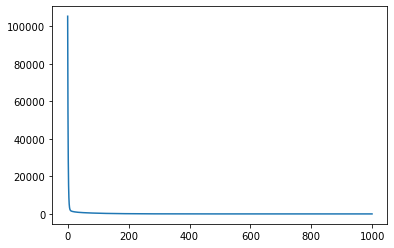

In [2263]:
plt.plot(np.arange(len(cost)), cost)

In [2264]:
predictions = model.predict(x_test)
predictions

array([[484.46659498],
       [443.30537292],
       [444.58669526],
       ...,
       [432.39575308],
       [443.20269095],
       [451.17256903]])

In [2265]:
y_n = y_test
p_n = predictions.reshape(len(predictions))

In [2266]:
np.sum((p_n - y_n)**2) / len(y_test)

26.27359218731829

##### L1-Regularization

In [2267]:
model = BGD_Reg(max_iter=1000, learning_rate=1e-4, store_cost_while_fitting=True, l1 = .2)

In [2268]:
cost = model.fit(x_train, y_train)

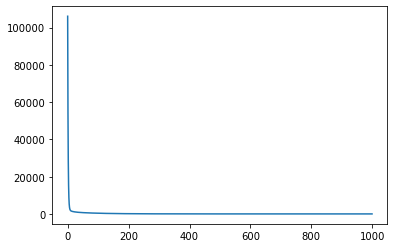

In [2269]:
plt.plot(np.arange(len(cost)), cost)

In [2270]:
predictions = model.predict(x_test)
predictions

array([[483.27521152],
       [443.62099899],
       [443.73507142],
       ...,
       [431.70442793],
       [443.13455968],
       [451.07627301]])

In [2271]:
y_n = y_test
p_n = predictions.reshape(len(predictions))

In [2272]:
np.sum((p_n - y_n)**2) / len(y_test)

26.6514576976215

##### Elastic Net Regularization

In [2273]:
model = BGD_Reg(max_iter=1000, learning_rate=1e-4, store_cost_while_fitting=True, l1 = 1, l2 = 2)

In [2274]:
cost = model.fit(x_train, y_train)

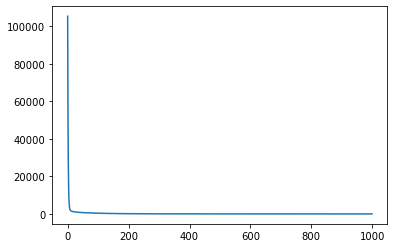

In [2275]:
plt.plot(np.arange(len(cost)), cost)

In [2276]:
predictions = model.predict(x_test)
predictions

array([[482.1102171 ],
       [443.93974038],
       [442.8940671 ],
       ...,
       [431.03732441],
       [443.07520238],
       [450.98617064]])

In [2277]:
np.sum((p_n - y_n)**2) / len(y_test)

26.6514576976215

## Mini Batch Gradient Descent

In [2278]:

import numpy as np

class MBGD_Reg:
    "Implementation of batch gradient descent"
    def __init__(self, learning_rate = 1e-5 , batch_size = 16, max_iter = 500, initial_theta_strategy = 'normal', store_cost_while_fitting = False, l1 = 0, l2 = 0):
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.max_iter = max_iter
        self.initial_theta_strategy = initial_theta_strategy
        self.store_cost_while_fitting = store_cost_while_fitting
        self.l1 = l1
        self.l2 = l2
    
    def fit(self, X,y):
        """
        Computes the value of theta, 
        which is stored in self.theta,
        Parameters
        ------------------------------------------
        X: numoy array, an array of the features 
           also it should be scaled
        y: numpy array, an array of the target

        Returns
        ------------------------------------------
        None
        """
        X_arr = X # convert the data frame to numpy arrayk
        N = len(X_arr) # number of trainning examples
        y_arr = y.reshape((N,1)) # convert the data frame to numpy array
        d = len(X_arr[0]) # number of features
        assert self.batch_size < N # ensure that batch size is less than N        
        no_epochs = N // self.batch_size
        cost_arr = []
        self._initialize_theta(d)
        counter = 0
        while counter < self.max_iter:
            for i in range(no_epochs-1):
                X_current = X_arr[ i * self.batch_size : (i+1) * self.batch_size ,:]
                y_current = y_arr[ i * self.batch_size : (i+1) * self.batch_size ,:]
                self.theta -= self.learning_rate * (X_current.T @ (X_current @ self.theta - y_current) + self._reg_grad())
            if self.store_cost_while_fitting:
                cost_arr.append(self.cost(X_arr, y_arr)[0][0])
            counter += 1
        if self.store_cost_while_fitting:
            return cost_arr

    def predict(self, X):
        """
        Parameters
        ------------------------------------------
        X: numpy array, an array of the input features

        Returns
        ------------------------------------------
        result: numpy array, array of the predicted values
        """
        result = X @ self.theta
        return result
    def cost(self, X, y):
        """
        Parameters:
        ------------------------------------------
        X: numpy array, the input array
        y: numpy array, array of the target values

        Returns
        ------------------------------------------
        result: float, the mean squared error
        """
        N = len(X) # the number of training examples
        predictions = self.predict(X)
        result = np.dot((predictions - y).T, predictions - y)/N
        return result

    def _initialize_theta(self,d):
        """
        initialize theta with values based on
        the attribute initial_theta_strategy
        Parameters:
        -----------------------------------------
        d: int, the number of features
        """
        if self.initial_theta_strategy == "normal":
            self.theta = np.random.randn(d,1)
        elif self.initial_theta_strategy == 'zeros':
            self.theta = np.zeros((d,1))
        elif self.initial_theta_strategy == 'ones':
            self.theta = np.ones((d,1))
    def _reg_grad(self):
        d = len(self.theta)
        return self.l2 * self.theta.reshape(d,1) + self.l1 * (2 * (self.theta > 0).astype(int) - 1).reshape(d,1) 

##### L2 Regularization

In [2279]:
model = MBGD_Reg(max_iter=1000, learning_rate=1e-4, store_cost_while_fitting=True, l2 = .01)

In [2280]:
cost = model.fit(x_train, y_train)

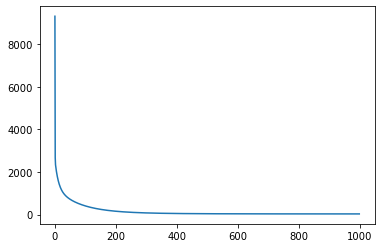

In [2281]:
plt.plot(np.arange(len(cost)), cost)

In [2282]:
predictions = model.predict(x_test)
predictions

array([[479.08694839],
       [444.82319853],
       [440.7171994 ],
       ...,
       [429.35136355],
       [442.96670082],
       [450.78883102]])

In [2283]:
np.sum((p_n - y_n)**2) / len(y_test)

26.6514576976215

##### L1 Regularization

In [2284]:
model = MBGD_Reg(max_iter=1000, learning_rate=1e-4, store_cost_while_fitting=True, l1 = .01)

In [2285]:
cost = model.fit(x_train, y_train)

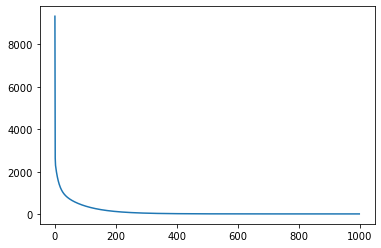

In [2286]:
plt.plot(np.arange(len(cost)), cost)

In [2287]:
predictions = model.predict(x_test)
predictions

array([[484.48064218],
       [443.33812423],
       [444.63301642],
       ...,
       [432.41846656],
       [443.2342053 ],
       [451.2073197 ]])

In [2288]:
np.sum((p_n - y_n)**2) / len(y_test)

26.6514576976215

##### Elastic Net Regularization

In [2289]:
model = MBGD_Reg(max_iter=1000, learning_rate=1e-4, store_cost_while_fitting=True, l1 = 2, l2 = 1)

In [2290]:
cost = model.fit(x_train, y_train)

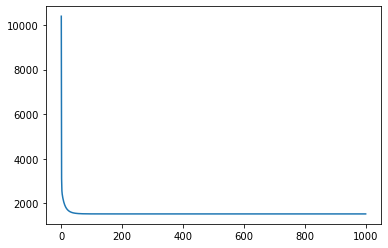

In [2291]:
plt.plot(np.arange(len(cost)), cost)

In [2292]:
predictions = model.predict(x_test)
predictions

array([[393.87763366],
       [464.9461811 ],
       [396.52608217],
       ...,
       [417.22296274],
       [444.59542391],
       [442.80704237]])

In [2293]:
np.sum((p_n - y_n)**2) / len(y_test)

26.6514576976215

## Stochastic gradient descent

In [2294]:
import numpy as np
import random
class SGD_Reg:
    "Implementation of stochastic batch gradient descent"
    def __init__(self, learning_rate = 1e-4 ,  max_iter = 100000, initial_theta_strategy = 'normal', store_cost_while_fitting = False, l1 = 0, l2= 0):
        self.learning_rate = learning_rate
        self.max_iter = max_iter
        self.initial_theta_strategy = initial_theta_strategy
        self.store_cost_while_fitting = store_cost_while_fitting
        self.l1 = l1
        self.l2 = l2
    
    def fit(self, X,y):
        N = len(X) # number of trainning examples
        d = len(X[0]) # number of features
        X_arr = X.copy() # convert the data frame to numpy array
        y_arr = y.reshape((N,1)).copy() # convert the data frame to numpy array
        cost_arr = []
        self._initialize_theta(d)
        counter = 0
        while counter < self.max_iter:
            #np.random.shuffle(X_arr)
            indices = np.arange(len(X_arr))
            np.random.shuffle(indices)
            X_arr = X_arr[indices]
            y_arr = y_arr[indices]
            for i in range(0,N):
                self.theta -= self.learning_rate * (X_arr[i, :].reshape(d,1) * (np.dot(X_arr[i,:],self.theta) - y_arr[i]) + self._reg_grad())
            if self.store_cost_while_fitting:
                cost_arr.append(self.cost(X, y))
            counter += 1
        if self.store_cost_while_fitting:
            return cost_arr

    def predict(self, X):
        """
        Parameters
        ------------------------------------------
        X: numpy array, an array of the input features

        Returns
        ------------------------------------------
        result: numpy array, array of the predicted values
        """
        result = X @ self.theta
        return result
    def cost(self, X, y):
        """
        Parameters:
        ------------------------------------------
        X: numpy array, the input array
        y: numpy array, array of the target values

        Returns
        ------------------------------------------
        result: float, the mean squared error
        """
        N = len(X) # the number of training examples
        y = y.reshape(N,1)
        predictions = self.predict(X)
        result = np.dot((predictions - y).T, predictions - y)/N
        return result[0][0]

    def _initialize_theta(self,d):
        """
        initialize theta with values based on
        the attribute initial_theta_strategy
        Parameters:
        -----------------------------------------
        d: int, the number of features
        """
        if self.initial_theta_strategy == "normal":
            self.theta = np.random.randn(d,1)
        elif self.initial_theta_strategy == 'zeros':
            self.theta = np.zeros((d,1))
        elif self.initial_theta_strategy == 'ones':
            self.theta = np.ones((d,1))
            
    def _reg_grad(self):
        d = len(self.theta)
        return self.l2 * self.theta.reshape(d,1) + self.l1 * (2 * (self.theta > 0).astype(int) - 1).reshape(d,1)




##### L2 Regularization

In [2295]:
model = SGD_Reg(max_iter=500, learning_rate=1e-5, store_cost_while_fitting=True, l2 = .01)

In [2296]:
cost = model.fit(x_train, y_train)

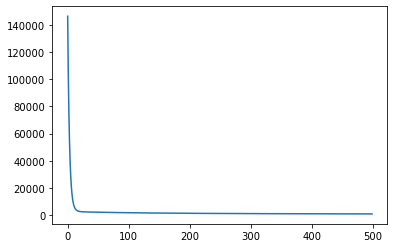

In [2297]:
plt.plot(np.arange(len(cost)), cost)

In [2298]:
predictions = model.predict(x_test)
predictions

array([[423.72917411],
       [465.16688414],
       [401.37499037],
       ...,
       [408.40327821],
       [445.4622599 ],
       [449.24567705]])

In [2299]:
np.sum((predictions.reshape(-1) - y_test.reshape(-1))**2) / len(y_test)

796.8385740510693

##### L1 Regularization

In [2300]:
model = SGD_Reg(max_iter=1000, learning_rate=1e-4, store_cost_while_fitting=True, l1 = .01)

In [2301]:
cost = model.fit(x_train, y_train)

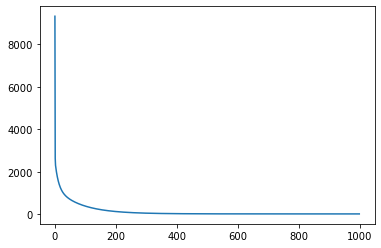

In [2302]:
plt.plot(np.arange(len(cost)), cost)

In [2303]:
predictions = model.predict(x_test)
predictions

array([[484.11571551],
       [443.45306693],
       [444.34732334],
       ...,
       [432.21828284],
       [443.22458898],
       [451.1830258 ]])

In [2304]:
np.sum((predictions.reshape(-1) - y_test.reshape(-1))**2) / len(y_test)

26.33090130419711

##### Elastic Net Regularization

In [2305]:
model = SGD_Reg(max_iter=1000, learning_rate=1e-4, store_cost_while_fitting=True, l1 = .01, l2 = .2)

In [2306]:
cost = model.fit(x_train, y_train)

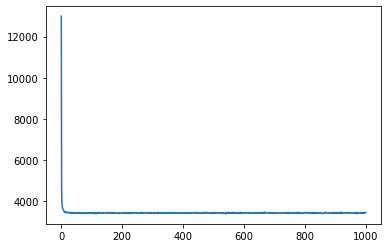

In [2307]:
plt.plot(np.arange(len(cost)), cost)

In [2308]:
predictions = model.predict(x_test)
predictions

array([[356.03911466],
       [446.78031315],
       [378.40849454],
       ...,
       [408.81019318],
       [427.00805285],
       [420.92135776]])

In [2309]:
np.sum((p_n - y_n)**2) / len(y_test)

26.6514576976215

## the affect of regularization on weights

In [2321]:
#for lambda between [-10, 10]
# make new model with this lamda 
#save theta

result_1 = []
result_2 = []
result_3 = []
for l2 in np.linspace(0,10,15):
    print(l2)
    model_1= BGD_Reg(max_iter=100, learning_rate=1e-4, store_cost_while_fitting=True, l1 = 0, l2=l2)
    model_2 = SGD_Reg(max_iter=10, learning_rate=1e-2, store_cost_while_fitting=True, l1 = 0, l2 =l2)
    model_3 = MBGD_Reg(max_iter=100, learning_rate=1e-4, store_cost_while_fitting=True, l1 = 0, l2 =l2)
    
    model_1.fit(x_train,y_train)
    model_2.fit(x_train,y_train)
    model_3.fit(x_train,y_train)
    
    l2_norm_theta_1 = np.sum((model_1.theta)**2)
    l2_norm_theta_2 = np.sum((model_2.theta)**2)
    l2_norm_theta_3 = np.sum((model_3.theta)**2)
    
    result_1.append(l2_norm_theta_1)
    result_2.append(l2_norm_theta_2)
    result_3.append(l2_norm_theta_3)

0.0
0.7142857142857143
1.4285714285714286
2.142857142857143
2.857142857142857
3.5714285714285716
4.285714285714286
5.0
5.714285714285714
6.428571428571429
7.142857142857143
7.857142857142858
8.571428571428571
9.285714285714286
10.0


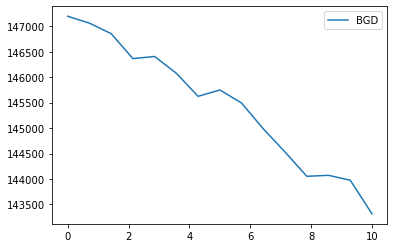

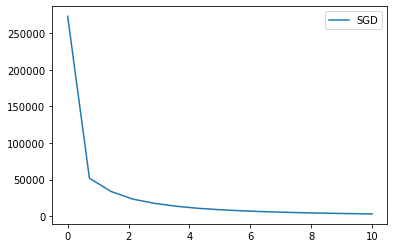

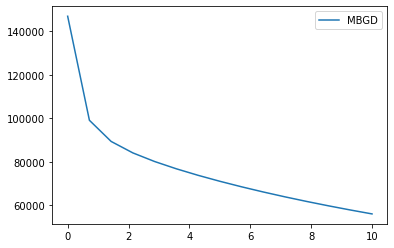

In [2322]:
plt.figure()
plt.plot(np.linspace(0,10,15),result_1, label = 'BGD')
plt.legend()
plt.figure()
plt.plot(np.linspace(0,10,15),result_2, label = 'SGD')
plt.legend()
plt.figure()
plt.plot(np.linspace(0,10,15),result_3, label = 'MBGD')
plt.legend()

* We notice that when the value of lambda increases, the norm of the weights decreases.

In [2323]:
#for lambda between [-10, 10]
# make new model with this lamda 
#save theta

result_1 = []
result_2 = []
result_3 = []
for l1 in np.linspace(0,10,15):
    print(l1)
    model_1= BGD_Reg(max_iter=100, learning_rate=1e-4, store_cost_while_fitting=True, l1 = l1, l2=0)
    model_2 = SGD_Reg(max_iter=100, learning_rate=1e-2, store_cost_while_fitting=True, l1 = l1, l2 =0)
    model_3 = MBGD_Reg(max_iter=100, learning_rate=1e-4, store_cost_while_fitting=True, l1 = l1, l2 =0)
    
    model_1.fit(x_train,y_train)
    model_2.fit(x_train,y_train)
    model_3.fit(x_train,y_train)
    
    l1_norm_theta_1 = np.sum((model_1.theta)**2)
    l1_norm_theta_2 = np.sum((model_2.theta)**2)
    l1_norm_theta_3 = np.sum((model_3.theta)**2)
    
    result_1.append(l1_norm_theta_1)
    result_2.append(l1_norm_theta_2)
    result_3.append(l1_norm_theta_3)

0.0
0.7142857142857143
1.4285714285714286
2.142857142857143
2.857142857142857
3.5714285714285716
4.285714285714286
5.0
5.714285714285714
6.428571428571429
7.142857142857143
7.857142857142858
8.571428571428571
9.285714285714286
10.0


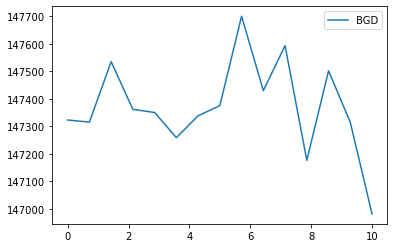

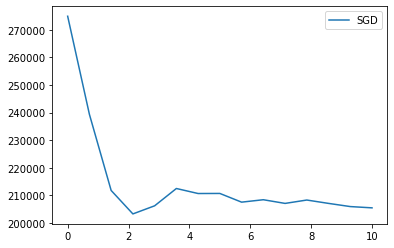

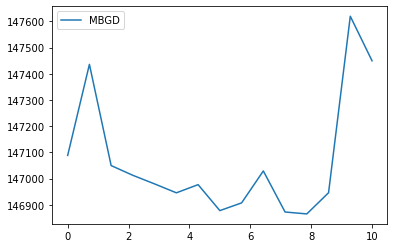

In [2324]:
plt.figure()
plt.plot(np.linspace(0,10,15),result_1, label = 'BGD')
plt.legend()
plt.figure()
plt.plot(np.linspace(0,10,15),result_2, label = 'SGD')
plt.legend()
plt.figure()
plt.plot(np.linspace(0,10,15),result_3, label = 'MBGD')
plt.legend()

## Solving step 4 and 5 individually

In [2464]:
import numpy as np
class BGD_Reg():
    "Implementation of batch gradient descent"
    def __init__(self, learning_rate = 1e-5 ,  max_iter = 500, initial_theta_strategy = 'normal', store_cost_while_fitting = False, l1 = 0, l2 = 1,kFold = 5):
        self.learning_rate = learning_rate
        self.max_iter = max_iter
        self.initial_theta_strategy = initial_theta_strategy
        self.store_cost_while_fitting = store_cost_while_fitting
        self.l1 = l1
        self.l2 = l2
        self.kFold = kFold
    
    def fit(self, X,y):
        """
        Computes the value of theta, 
        which is stored in self.theta,
        Parameters
        ------------------------------------------
        X: numoy array, an array of the features 
           also it should be scaled
        y: numpy array, an array of the target

        Returns
        ------------------------------------------
        None
        """
        N = len(X) # number of trainning examples
        d = len(X[0]) # number of features
        X_arr = X # convert the data frame to numpy array
        y_arr = y.reshape((N,1)) # convert the data frame to numpy array
        cost_arr = []
        self._initialize_theta(d)
        counter = 0
        while counter < self.max_iter:
            self.theta -= self.learning_rate * (X_arr.T @ (X_arr @ self.theta - y_arr) + self._reg_grad())

            if self.store_cost_while_fitting:
                cost_arr.append(self.cost(X, y))
            counter += 1
        if self.store_cost_while_fitting:
            return cost_arr
        
        
    def predict(self, X):
        """
        Parameters
        ------------------------------------------
        X: numpy array, an array of the input features

        Returns
        ------------------------------------------
        result: numpy array, array of the predicted values
        """
        result = X @ self.theta
        return result

    def cost(self, X, y):
        """
        Parameters:
        ------------------------------------------
        X: numpy array, the input array
        y: numpy array, array of the target values

        Returns
        ------------------------------------------
        result: float, the mean squared error
        """
        N = len(X) # the number of training examples
        y = y.reshape(N,1)
        predictions = self.predict(X)
        result = np.dot((predictions - y).T, predictions - y)/N
        return result[0][0]

    def _initialize_theta(self,d):
        """
        initialize theta with values based on
        the attribute initial_theta_strategy
        Parameters:
        -----------------------------------------
        d: int, the number of features
        """
        if self.initial_theta_strategy == "normal":
            self.theta = np.random.randn(d,1)
        elif self.initial_theta_strategy == 'zeros':
            self.theta = np.zeros((d,1))
        elif self.initial_theta_strategy == 'ones':
            self.theta = np.ones((d,1))
    def _reg_grad(self):
        d = len(self.theta)
        return self.l2 * self.theta.reshape(d,1) + self.l1 * (2 * (self.theta > 0).astype(int) - 1).reshape(d,1) 

    def cross_validation(self, model, data, kFold):
      #split train set in kfold chunks
        #folds = np.array_split(data, kFold)
        rmse_l_validation = []
        clist = []
        counter = 0
        data_arr = data.to_numpy()
        X,y = data_arr[:,:-1], data_arr[:,-1]
        X = X/X.max()
        fold_size = len(X) // kFold
        
        for fold in range(kFold):
            print("fold size", fold_size)
            print(X[(fold+1)*fold_size:,:].shape)
            x_train = np.vstack((X[0:fold*fold_size,:] , X[(fold+1)*fold_size:,:]))
            y_train = np.hstack((y[0:fold*fold_size].reshape(-1) , y[(fold+1)*fold_size:].reshape(-1)))
            print(y_train)
            x_test  = X[fold*fold_size:(fold+1)*fold_size,:]
            y_test  = y[fold*fold_size:(fold+1)*fold_size] 
            
            

#             train_set = list(folds) #Put all folds in train
#             train_set.pop(counter)
            
#             #train_set = pd.concat(train_set) #drop current fold
#             validation_set = fold #current fold is validation set
#             x_train,y_train = train_set[:,:-1], train_set[:-1]
#             x_train,y_train = train_set[:,:-1], train_set[:,-1]


            model = BGD_Reg(max_iter=1000, learning_rate=1e-4, store_cost_while_fitting=True, l1 = 1, l2 = 2,kFold = 5)
            model.fit(x_train, y_train)
            #(train_set, validation_set, beta, alpha, batchsize, itera, regu, var)
            predictions = model.predict(x_test)
            mse = np.sum((predictions - y_test)**2)/len(predictions)
            rmse_l_validation.append(mse)
    
        fold_rmse = np.average(rmse_l_validation) #get average rmse for a hyperparameter set over all kfolds
        return fold_rmse

In [2465]:
model = BGD_Reg(max_iter=100, learning_rate=1e-5, store_cost_while_fitting=True, l1 = 0, l2 = 2,kFold = 10)

In [2466]:
model.cross_validation(model, data, kFold = 5)

fold size 1913
(7655, 4)
[468.75 473.27 471.32 ... 429.57 435.74 453.28]
fold size 1913
(5742, 4)
[463.26 444.37 488.56 ... 429.57 435.74 453.28]
fold size 1913
(3829, 4)
[463.26 444.37 488.56 ... 429.57 435.74 453.28]
fold size 1913
(1916, 4)
[463.26 444.37 488.56 ... 429.57 435.74 453.28]
fold size 1913
(3, 4)
[463.26 444.37 488.56 ... 429.57 435.74 453.28]


587828.8704881633

In [2467]:
import numpy as np
import random
class SGD_Reg:
    "Implementation of stochastic batch gradient descent"
    def __init__(self, learning_rate = 1e-4 ,  max_iter = 100000, initial_theta_strategy = 'normal', store_cost_while_fitting = False, l1 = 0, l2= 1, kFold = 5):
        self.learning_rate = learning_rate
        self.max_iter = max_iter
        self.initial_theta_strategy = initial_theta_strategy
        self.store_cost_while_fitting = store_cost_while_fitting
        self.l1 = l1
        self.l2 = l2
        self.kFold = kFold
    
    def fit(self, X,y):
        N = len(X) # number of trainning examples
        d = len(X[0]) # number of features
        X_arr = X.copy() # convert the data frame to numpy array
        y_arr = y.reshape((N,1)).copy() # convert the data frame to numpy array
        cost_arr = []
        self._initialize_theta(d)
        counter = 0
        while counter < self.max_iter:
            #np.random.shuffle(X_arr)
            indices = np.arange(len(X_arr))
            np.random.shuffle(indices)
            X_arr = X_arr[indices]
            y_arr = y_arr[indices]
            for i in range(0,N):
                self.theta -= self.learning_rate * (X_arr[i, :].reshape(d,1) * (np.dot(X_arr[i,:],self.theta) - y_arr[i]) + self._reg_grad())
            if self.store_cost_while_fitting:
                cost_arr.append(self.cost(X, y))
            counter += 1
        if self.store_cost_while_fitting:
            return cost_arr

    def predict(self, X):
        """
        Parameters
        ------------------------------------------
        X: numpy array, an array of the input features

        Returns
        ------------------------------------------
        result: numpy array, array of the predicted values
        """
        result = X @ self.theta
        return result
    def cost(self, X, y):
        """
        Parameters:
        ------------------------------------------
        X: numpy array, the input array
        y: numpy array, array of the target values

        Returns
        ------------------------------------------
        result: float, the mean squared error
        """
        N = len(X) # the number of training examples
        y = y.reshape(N,1)
        predictions = self.predict(X)
        result = np.dot((predictions - y).T, predictions - y)/N
        return result[0][0]

    def _initialize_theta(self,d):
        """
        initialize theta with values based on
        the attribute initial_theta_strategy
        Parameters:
        -----------------------------------------
        d: int, the number of features
        """
        if self.initial_theta_strategy == "normal":
            self.theta = np.random.randn(d,1)
        elif self.initial_theta_strategy == 'zeros':
            self.theta = np.zeros((d,1))
        elif self.initial_theta_strategy == 'ones':
            self.theta = np.ones((d,1))
            
    def _reg_grad(self):
        d = len(self.theta)
        return self.l2 * self.theta.reshape(d,1) + self.l1 * (2 * (self.theta > 0).astype(int) - 1).reshape(d,1)
    
    def cross_validation(self, model, data, kFold):
      #split train set in kfold chunks
        #folds = np.array_split(data, kFold)
        rmse_l_validation = []
        clist = []
        counter = 0
        data_arr = data.to_numpy()
        X,y = data_arr[:,:-1], data_arr[:,-1]
        X = X/X.max()
        fold_size = len(X) // kFold
        
        for fold in range(kFold):
            print("fold size", fold_size)
            print(X[(fold+1)*fold_size:,:].shape)
            x_train = np.vstack((X[0:fold*fold_size,:] , X[(fold+1)*fold_size:,:]))
            y_train = np.hstack((y[0:fold*fold_size].reshape(-1) , y[(fold+1)*fold_size:].reshape(-1)))
            print(y_train)
            x_test  = X[fold*fold_size:(fold+1)*fold_size,:]
            y_test  = y[fold*fold_size:(fold+1)*fold_size] 
        

            model = SGD_Reg(max_iter=100, learning_rate=1e-5, store_cost_while_fitting=True, l1 = 0, l2 = 2,kFold = 10)
            #model = BGD_Reg(max_iter=1000, learning_rate=1e-4, store_cost_while_fitting=True, l1 = 1, l2 = 2,kFold = 5)
            model.fit(x_train, y_train)
            #(train_set, validation_set, beta, alpha, batchsize, itera, regu, var)
            predictions = model.predict(x_test)
            mse = np.sum((predictions - y_test)**2)/len(predictions)
            rmse_l_validation.append(mse)
    
        fold_rmse = np.average(rmse_l_validation) #get average rmse for a hyperparameter set over all kfolds
        return fold_rmse

In [2472]:
model = SGD_Reg(max_iter=100, learning_rate=1e-4, store_cost_while_fitting=True, l1 = 1, l2 = 2,kFold = 5)

In [2473]:
model.cross_validation(model, data, kFold = 5)

fold size 1913
(7655, 4)
[468.75 473.27 471.32 ... 429.57 435.74 453.28]
fold size 1913
(5742, 4)
[463.26 444.37 488.56 ... 429.57 435.74 453.28]
fold size 1913
(3829, 4)
[463.26 444.37 488.56 ... 429.57 435.74 453.28]
fold size 1913
(1916, 4)
[463.26 444.37 488.56 ... 429.57 435.74 453.28]
fold size 1913
(3, 4)
[463.26 444.37 488.56 ... 429.57 435.74 453.28]


179671289.6731905